# Sentiment Analysis of *The Times* Music Reviews
## Part III: Data Visualization
*How have artforms been reported?  Is there a status hierarchy between them?  How has this changed over time?*

* **Project:** What counts as culture?  Reporting and criticism in The Times 1785-2000
* **Project Lead:** Dave O'Brien
* **Developer:** Lucy Havens
* **Funding:** from the Centre for Data, Culture & Society, University of Edinburgh
* **Dataset:** 83,625 reviews about music published in The Times from 1950 through 2009

Begun February 2021

***

### 1. Load the Data

First, import required programming libraries.

In [25]:
# For data loading
import re
import string
import numpy as np
import pandas as pd

# For text analysis
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
# nltk.download('punkt')
from nltk.corpus import PlaintextCorpusReader
# nltk.download('wordnet')
from nltk.corpus import wordnet
# nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.text import Text
# nltk.download('averaged_perceptron_tagger')
# nltk.download('tagsets')  # part of speech tags
from nltk.tag import pos_tag

# For data visualization
import matplotlib.pyplot as plt
import altair as alt   ###  Need to figure out why Altair returns error! (Javascript Error: Unrecognized transform type: "formula")
import seaborn as sns

Next, load the data from the VADER sentiment analyzer run on The Times reviews' text and load the inventory data.

We'll load these datasets into DataFrames, organizing the CSV file into rows and columns just as it was in the Sentiment Analysis Notebook (#2).

In [2]:
dfs = pd.read_csv("../TheTimes_DaveO/TheTimesArticles_1950-2009_VADERSentiments.csv", index_col=0)
dfs.rename(columns={"article_id":"filepath"}, inplace=True)
dfs.head()

,filepath,compound,positive,neutral,negative
0,TheTimesMusicReviews_1950-2009_part1/20787,0.9897,0.075,0.912,0.013
1,TheTimesMusicReviews_1950-2009_part1/20788,0.9978,0.230,0.744,0.025
2,TheTimesMusicReviews_1950-2009_part1/20789,0.9912,0.124,0.866,0.010
3,TheTimesMusicReviews_1950-2009_part1/20790,0.9886,0.133,0.822,0.044
4,TheTimesMusicReviews_1950-2009_part1/20791,0.8225,0.061,0.893,0.046


In [3]:
dfi = pd.read_csv("../TheTimes_DaveO/TheTimesArticles_1950-2009_Inventory.csv")
dfi.rename(columns={"Unnamed: 0":"identifier"}, inplace=True)
dfi.head()

,identifier,title,year,author,term,section,pages,filename,article_id,issue_id
0,20787,SOME NEW SCORES MOTET AND OPERA,1950,BY OUR MUSIC CRITIC,"[' bands', ' composer', ' musical', ' opera', ...",Reviews,[],/lustre/home/dc125/shared/TDA_GDA_1785-2009/19...,0FFO-1950-JUN30-008-023,0FFO-1950-JUN30
1,20788,"THE ROYAL OPERA "" TRISTAN AND ISOLDE """,1950,'',"[' opera', ' orchestra']",Reviews,[],/lustre/home/dc125/shared/TDA_GDA_1785-2009/19...,0FFO-1950-JUN30-008-027,0FFO-1950-JUN30
2,20789,GROWING TASTE FOR MUSIC PLEA FOR ENLARGED QUEE...,1950,'',[' country'],Reviews,[],/lustre/home/dc125/shared/TDA_GDA_1785-2009/19...,0FFO-1950-JUN30-008-032,0FFO-1950-JUN30
3,20790,ROYAL PHILHARMONIC CONCERT BEECHAM AND MOZART,1950,'',"[' orchestra', ' orchestras']",Reviews,['010'],/lustre/home/dc125/shared/TDA_GDA_1785-2009/19...,0FFO-1950-MAR02-010-006,0FFO-1950-MAR02
4,20791,MUSICAL JOURNALS SOME NEWCOMERS,1950,BY OUR MUSIC CRITIC,"[' musical', ' orchestra', ' orchestras']",Reviews,['007'],/lustre/home/dc125/shared/TDA_GDA_1785-2009/19...,0FFO-1950-MAR03-007-010,0FFO-1950-MAR03


Now we can merge these two DataFrames together using the `filepath` column from the first DataFrame and the `identifer` column from the second DataFrame.

In [4]:
paths = list(dfs.filepath)
ids = []
for p in paths:
    ids += [int((re.findall("\d{1,}$",p))[0])]
    
print(ids[:10]) # print the first 10 ids

[20787, 20788, 20789, 20790, 20791, 20792, 20793, 20794, 20795, 20796]


Add an `identifier` column to the first DataFrame of sentiment analysis results.

In [5]:
dfs["identifier"] = ids
dfs.head(3)

,filepath,compound,positive,neutral,negative,identifier
0,TheTimesMusicReviews_1950-2009_part1/20787,0.9897,0.075,0.912,0.013,20787
1,TheTimesMusicReviews_1950-2009_part1/20788,0.9978,0.230,0.744,0.025,20788
2,TheTimesMusicReviews_1950-2009_part1/20789,0.9912,0.124,0.866,0.010,20789


Now we can join the DataFrames on their `identifier` columns!

In [6]:
df = dfi.merge(dfs, how="outer", on="identifier")
df.head(3)

,identifier,title,year,author,term,section,pages,filename,article_id,issue_id,filepath,compound,positive,neutral,negative
0,20787,SOME NEW SCORES MOTET AND OPERA,1950.0,BY OUR MUSIC CRITIC,"[' bands', ' composer', ' musical', ' opera', ...",Reviews,[],/lustre/home/dc125/shared/TDA_GDA_1785-2009/19...,0FFO-1950-JUN30-008-023,0FFO-1950-JUN30,TheTimesMusicReviews_1950-2009_part1/20787,0.9897,0.075,0.912,0.013
1,20788,"THE ROYAL OPERA "" TRISTAN AND ISOLDE """,1950.0,'',"[' opera', ' orchestra']",Reviews,[],/lustre/home/dc125/shared/TDA_GDA_1785-2009/19...,0FFO-1950-JUN30-008-027,0FFO-1950-JUN30,TheTimesMusicReviews_1950-2009_part1/20788,0.9978,0.230,0.744,0.025
2,20789,GROWING TASTE FOR MUSIC PLEA FOR ENLARGED QUEE...,1950.0,'',[' country'],Reviews,[],/lustre/home/dc125/shared/TDA_GDA_1785-2009/19...,0FFO-1950-JUN30-008-032,0FFO-1950-JUN30,TheTimesMusicReviews_1950-2009_part1/20789,0.9912,0.124,0.866,0.010


It looks like our year column isn't appearing properly: we want every year value to be a four-digit integer where the year is given or 0 where the year is unknown.

In [7]:
df.year.unique()

array([1950., 1951., 1952., 1953., 1954., 1955., 1956., 1957., 1958.,
       1959., 1960., 1961., 1962., 1963., 1964., 1965., 1966., 1967.,
       1968., 1969., 1970., 1971., 1972., 1973., 1974., 1975., 1976.,
       1977., 1978., 1979., 1980., 1981., 1982., 1983., 1984., 1985.,
       2000., 1986., 1987., 1988., 1989., 1990., 1991., 1992., 1993.,
       1994., 1995., 1996., 1997., 1998., 1999., 2001., 2002., 2003.,
       2004., 2005., 2006., 2007., 2008., 2009.,   nan])

In [8]:
df.year = df.year.fillna(0)
df.year.unique()
df = df.astype({"year": "int32"})

For good measure, let's define how we want other empty cell values to be represented for the other columns we'll be working with.

In [9]:
df.term = df.term.fillna("")
df.title = df.title.fillna("")
df.section = df.section.fillna("")
df.pages = df.pages.fillna("")
df.head(3)

,identifier,title,year,author,term,section,pages,filename,article_id,issue_id,filepath,compound,positive,neutral,negative
0,20787,SOME NEW SCORES MOTET AND OPERA,1950,BY OUR MUSIC CRITIC,"[' bands', ' composer', ' musical', ' opera', ...",Reviews,[],/lustre/home/dc125/shared/TDA_GDA_1785-2009/19...,0FFO-1950-JUN30-008-023,0FFO-1950-JUN30,TheTimesMusicReviews_1950-2009_part1/20787,0.9897,0.075,0.912,0.013
1,20788,"THE ROYAL OPERA "" TRISTAN AND ISOLDE """,1950,'',"[' opera', ' orchestra']",Reviews,[],/lustre/home/dc125/shared/TDA_GDA_1785-2009/19...,0FFO-1950-JUN30-008-027,0FFO-1950-JUN30,TheTimesMusicReviews_1950-2009_part1/20788,0.9978,0.230,0.744,0.025
2,20789,GROWING TASTE FOR MUSIC PLEA FOR ENLARGED QUEE...,1950,'',[' country'],Reviews,[],/lustre/home/dc125/shared/TDA_GDA_1785-2009/19...,0FFO-1950-JUN30-008-032,0FFO-1950-JUN30,TheTimesMusicReviews_1950-2009_part1/20789,0.9912,0.124,0.866,0.010


That looks better!

Now the reviews' sentiment data are joined up with the reviews' metadata!  Let's export this file for quicker reference in the future.

In [10]:
df.to_csv("../TheTimes_DaveO/TheTimesArticles_1950-2009_MetadataWithVADERSentiments.csv")

### 2. Analyze the Data
#### 2.1 Summary Statistics
Let's figure out what the most positive, negative, and neutral reviews are and what scores VADER assigned them.

In [11]:
maxPos = max(df.positive)
print("Highest Positive Score:\n\t", maxPos)
print("Review with Highest Positive Score:\n\t", list(df.title[df.positive == maxPos])[0])

Highest Positive Score:
	 0.457
Review with Highest Positive Score:
	 \  \"The Feigned Lady Gardener\" doesnt exactly trip off the tongue , but\


In [12]:
maxNeg = max(df.negative)
print("Highest Negative Score:\n\t", maxNeg)
print("Review with Highest Negative Score:\n\t", list(df.title[df.negative == maxNeg])[0])

Highest Negative Score:
	 0.319
Review with Highest Negative Score:
	 The Art of Noise The1 week's best music video


In [13]:
maxNeu = max(df.neutral)
print("Highest Neutral Score:\n\t", maxNeu)
print("Review with Highest Neutral Score:\n\t", list(df.title[df.neutral == maxNeu])[0])

Highest Neutral Score:
	 1.0
Review with Highest Neutral Score:
	 BRITISH MUSIC SUNG AT ST. JOHN LATFRAN A CONTEMPORARY MASS


In [14]:
maxCom = max(df["compound"])
minCom = min(df["compound"])
print("Most Positive (Highest) Compound Score:\n\t", maxCom)
print("Review with Most Positive (Highest) Compount Score:\n\t", list(df.title[df["compound"] == maxCom])[0])
print("\nMost Negative (Lowest) Compound Score:\n\t", minCom)
print("Review with Most Negative (Lowest) Compount Score:\n\t", list(df.title[df["compound"] == minCom])[0])

Most Positive (Highest) Compound Score:
	 1.0
Review with Most Positive (Highest) Compount Score:
	 

Most Negative (Lowest) Compound Score:
	 -0.9998
Review with Most Negative (Lowest) Compount Score:
	 Who will take the rap for Tupac ?


To get a sense of how well the sentiment analyzer performs, we could read some of these reviews and judge for ourselves whether the VADER scores seem accurate!

#### 2.2 Analysis by Genre
The *defoe* text mining output reports the music-related terms that each review contains, so we can create subsets of our data based on the these terms.

In [15]:
# From https://github.com/defoe-code/defoe/blob/master/queries/music_genres.txt
genres = ['music', 'african', 'big band', 'bluegrass', 'country', 'blues', 'musical', 'classical', 
          'electronic', 'folk', 'gospel', 'hip hop', 'jazz', 'latin', 'metal', 'easy listening', 
          'opera', 'pop', 'rap', 'rave', 'reggae', 'rock']

musical_terms = ["song", "lyric", "album", "band", "artist", "singer", "songwriter", "rapper", "composer", 
                 "composition", "orchesra", "dj", "music"]

Let's start with an analysis of reviews that use the term **opera**.

**Step 1:** Identify which articles have the term "opera."

In [36]:
def termFilter(term_string, dataframe):
    df_terms = list(dataframe.term)
    with_term = []
    for t in df_terms:
        if term_string in t:
            with_term += [True]
        else:
            with_term += [False]
    
    assert(len(with_term) == len(df_terms))
    return with_term

with_opera = termFilter(" opera", df)

**Step 2:** Create a subset of the data that ONLY includes articles with the term "opera."

In [37]:
df["with_opera"] = with_opera
df_opera = df[df["with_opera"] == True]
print(df_opera.shape)

(18630, 17)


In [18]:
df_opera.tail()

,identifier,title,year,author,term,section,pages,filename,article_id,issue_id,filepath,compound,positive,neutral,negative,with_opera
83616,106791,"John Scrimger, Linda Ormiston, Marilyn HIII Smith",2009,'',"[' musical', ' opera']",Reviews,[],/lustre/home/dc125/shared/TDA_GDA_1785-2009/19...,0FFO-2009-0815-0268-006,0FFO-2009-0815,TheTimesMusicReviews_1950-2009_part2/106791,0.4939,0.084,0.916,0.000,True
83619,106794,'',2009,'',"[' classical', ' jazz', ' opera']",Reviews,[],/lustre/home/dc125/shared/TDA_GDA_1785-2009/19...,0FFO-2009-0815-0268-017,0FFO-2009-0815,TheTimesMusicReviews_1950-2009_part2/106794,0.9812,0.162,0.802,0.036,True
83620,106795,Which shows?,2009,'',"[' musical', ' opera', ' rock']",Reviews,['0271'],/lustre/home/dc125/shared/TDA_GDA_1785-2009/19...,0FFO-2009-0815-0271-002,0FFO-2009-0815,TheTimesMusicReviews_1950-2009_part2/106795,-0.9401,0.000,0.736,0.264,True
83626,106801,Desolate islands' ghostly power,2009,Richard Morrison,"[' band', ' electronic', ' opera', ' singers',...",Reviews,[],/lustre/home/dc125/shared/TDA_GDA_1785-2009/19...,0FFO-2009-0817-0080-003,0FFO-2009-0817,TheTimesMusicReviews_1950-2009_part2/106801,0.9452,0.100,0.840,0.060,True
83629,106804,"""Prom 39 BBCSO/Brabbins Albert Hall/Radio 3 w ...",2009,Hilary Finch,"[' electronic', ' musical', ' opera', ' orches...",Reviews,[],/lustre/home/dc125/shared/TDA_GDA_1785-2009/19...,0FFO-2009-0817-0081-001,0FFO-2009-0817,TheTimesMusicReviews_1950-2009_part2/106804,0.9849,0.142,0.805,0.053,True


**Step 3:** Calculate the maximum, minimum, and average compound sentiment scores.

In [19]:
print("Most positive opera review:", max(df_opera["compound"]))
print("Most negative opera review:", min(df_opera["compound"]))
print("Average opera review compound score:", np.mean(df_opera["compound"]))

Most positive opera review: 0.9998
Most negative opera review: -0.9990000000000001
Average opera review compound score: 0.8464726947380213


It looks like most of the reviews with the word "opera" are pretty positive!  Let's create a visualization of the data so we can get a better sense of the opera data overall.

**Step 4:** Graph the compound scores of reviews with the word "opera."

In [29]:
opera_compound = pd.DataFrame({"compound":list(df_opera["compound"]), "year":list(df_opera["year"])})
opera_yearly = opera_compound.groupby(by="year").mean().reset_index()
opera_yearly.tail()

,year,compound
55,2005,0.807725
56,2006,0.699977
57,2007,0.677652
58,2008,0.427553
59,2009,0.709304


In [47]:
min(opera_yearly["compound"])

0.427552857142857

[(0.4, 1),
 Text(0.5, 1.0, "Yearly Average Compound Sentiment Score for Reviews with the Term 'opera'")]

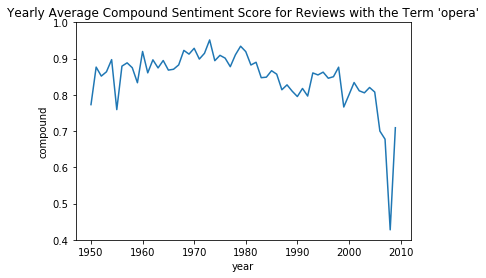

In [55]:
opera_viz = sns.lineplot(data=opera_yearly, x="year", y="compound")
opera_viz.set(ylim=(0.4,1),title="Yearly Average Compound Sentiment Score for Reviews with the Term 'opera'")

**Step 4:** Let's compare these results to the genre "rock."

In [38]:
with_rock = termFilter(" rock", df)
df["with_rock"] = with_rock
df_rock = df[df["with_rock"] == True]
print(df_rock.shape)
df_rock.head()

(9223, 17)


,identifier,title,year,author,term,section,pages,filename,article_id,issue_id,filepath,compound,positive,neutral,negative,with_opera,with_rock
321,21108,HASTINGS MUSIC FESTIVAL BRAHMS AND HAYDN,1950,FROM OUR SPECIAL CORRESPONDENT,"[' composers', ' musical', ' orchestra', ' roc...",Reviews,[],/lustre/home/dc125/shared/TDA_GDA_1785-2009/19...,0FFO-1950-JUN15-008-021,0FFO-1950-JUN15,TheTimesMusicReviews_1950-2009_part1/21108,0.9941,0.160,0.797,0.043,False,True
672,21459,THE CONCERT HALL PLATFORM DESIGN,1951,BY OUR MUSIC CRITIC,"[' orchestra', ' rock']",Reviews,[],/lustre/home/dc125/shared/TDA_GDA_1785-2009/19...,0FFO-1951-APR20-008-015,0FFO-1951-APR20,TheTimesMusicReviews_1950-2009_part1/21459,0.8622,0.067,0.890,0.043,False,True
713,21500,'''RECORDING BIRDS ON SCILLIES NIGHT FLIGHT OF...,1951,By Ludwig Koch,"[' rock', ' song']",Reviews,['006'],/lustre/home/dc125/shared/TDA_GDA_1785-2009/19...,0FFO-1951-AUG21-006-014,0FFO-1951-AUG21,TheTimesMusicReviews_1950-2009_part1/21500,0.9972,0.109,0.838,0.053,False,True
738,21525,THE HAMBURG ORCHESTRA A GERMAN PROGRAMME,1951,'',"[' composer', ' composers', ' musical', ' orch...",Reviews,[],/lustre/home/dc125/shared/TDA_GDA_1785-2009/19...,0FFO-1951-DEC01-008-016,0FFO-1951-DEC01,TheTimesMusicReviews_1950-2009_part1/21525,0.9899,0.148,0.794,0.058,False,True
930,21717,"GLYNDEBOUTRNE OPERA "" COSI FAN TUITE """,1951,FROM OUR SPECIAL CORRESPONDENT,"[' opera', ' orchestra', ' rock']",Reviews,['004'],/lustre/home/dc125/shared/TDA_GDA_1785-2009/19...,0FFO-1951-JUL02-004-018,0FFO-1951-JUL02,TheTimesMusicReviews_1950-2009_part1/21717,0.9452,0.106,0.870,0.024,True,True


In [39]:
print("Most positive rock review:", max(df_rock["compound"]))
print("Most negative rock review:", min(df_rock["compound"]))
print("Average rock review compound score:", np.mean(df_rock["compound"]))

Most positive rock review: 0.9998
Most negative rock review: -0.9992
Average rock review compound score: 0.774483790613715


On average, the reviews with the term "rock" have a slightly less positive score than reviews with the term "opera."

In [49]:
rock_compound = pd.DataFrame({"compound":list(df_rock["compound"]), "year":list(df_rock["year"])})
rock_yearly = rock_compound.groupby(by="year").mean().reset_index()
min(rock_yearly["compound"])

0.6008710526315794

[(0.4, 1),
 Text(0.5, 1.0, "Yearly Average Compound Sentiment Score for Reviews with the Term 'rock'")]

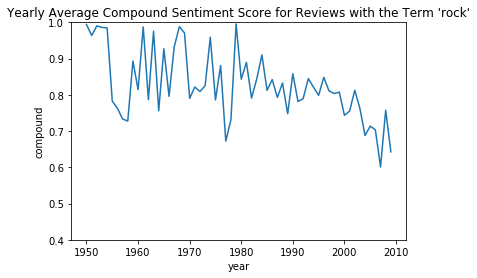

In [57]:
rock_viz = sns.lineplot(data=rock_yearly, x="year", y="compound")
rock_viz.set(ylim=(0.4, 1), title="Yearly Average Compound Sentiment Score for Reviews with the Term 'rock'")  # use the same y range as the opera visualization

This looks quite different from the "opera" visualization!  The sentiment fluctuates more from year to year and overall doesn't go drop as low as opera does.  Since 1980, both have a downward trend, moving towards less positive sentiment (though not reaching what the VADER documentation classifies as negative sentiment).

**Step 5:** How about reviews with the term "rap?"

In [58]:
with_rock = termFilter(" rap", df)
df["with_rap"] = with_rock
df_rap = df[df["with_rap"] == True]
print(df_rap.shape)
print("Most positive rock review:", max(df_rap["compound"]))
print("Most negative rock review:", min(df_rap["compound"]))
print("Average rock review compound score:", np.mean(df_rap["compound"]))
rap_compound = pd.DataFrame({"compound":list(df_rap["compound"]), "year":list(df_rap["year"])})
rap_yearly = rap_compound.groupby(by="year").mean().reset_index()
min(rap_yearly["compound"])

(1926, 18)
Most positive rock review: 0.9998
Most negative rock review: -0.9998
Average rock review compound score: 0.7483557208237988


0.500025

[(0.4, 1), Text(0.5, 1.0, "Yearly Avg Sentiment for 'rap' Reviews")]

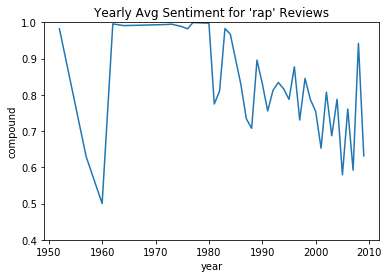

In [62]:
rap_viz = sns.lineplot(data=rap_yearly, x="year", y="compound")
rap_viz.set(ylim=(0.4, 1), title="Yearly Avg Sentiment for 'rap' Reviews")  # use the same y range as the opera visualization

Again a very different visualization!

Let's export all three charts for quick reference and comparison.

In [61]:
# opera_viz.figure.savefig("yearly_compound_opera.png")
# rock_viz.figure.savefig("yearly_compound_rock.png")
rap_viz.figure.savefig("yearly_compound_rap.png")

In [ ]:
# to try: https://seaborn.pydata.org/examples/timeseries_facets.html